# Spectral Analysis

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Let's construct a simple sine wave

In [2]:
dt = 0.01 # 1 ms interval between points
T_max = 5 # Signal lasts for 10 seconds
times = np.arange(0,T_max,dt)
N = len(times)
frequency = 4 # Frequency of sinusoid in Hz
offset = 0 # Phase offset in radians
signal = np.array(np.sin(2*np.pi*frequency*times+offset))

## And plot that sine wave

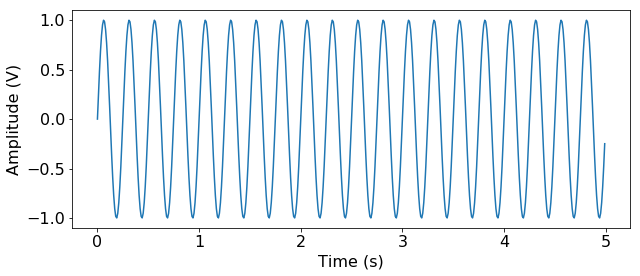

In [3]:
mpl.rcParams.update({'font.size':16})
def plot_signal(times,signal):
    plt.figure(figsize=(10,4))
    plt.plot(times,signal)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (V)');
plot_signal(times,signal)   

## Now we can compute the Fourier transform

In [4]:
from scipy import fft # The Fast Fourier Transform function

In [5]:
fft(signal)[:5] # Compute fast Fourier transform and show first 5 complex values

array([  1.75508027e-13 +0.00000000e+00j,
        -5.19412030e-14 +1.79604991e-13j,
         5.03008558e-14 -3.81411697e-14j,
        -4.69177073e-14 -1.65121878e-14j,   5.46698065e-15 +1.58597885e-14j])

In [6]:
magnitude = np.abs(fft(signal)) 
magnitude[:5] # Magnitudes of those 5 values

array([  1.75508027e-13,   1.86964813e-13,   6.31262618e-14,
         4.97385525e-14,   1.67756004e-14])

## We can compute the frequencies in the FFT from the time points in the original signal

In [7]:
df = 1/T_max
F_max = 1/dt
frequencies = np.arange(0,F_max,df)
frequencies[int(N/2):] -= F_max

## The resulting FFT magnitude vs frequency looks like this:

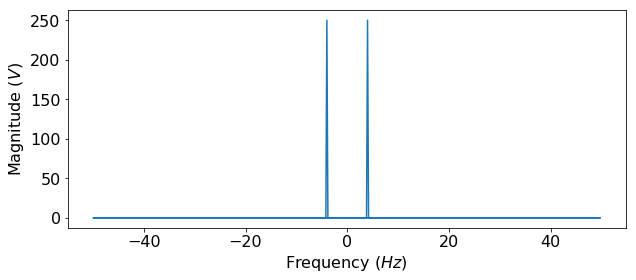

In [8]:
def plot_magnitude(frequencies,magnitude):
    plt.figure(figsize=(10,4))
    plt.plot(frequencies,magnitude)
    plt.xlabel('Frequency ($Hz$)')
    plt.ylabel('Magnitude ($V$)');
plot_magnitude(frequencies,magnitude)

## Negative frequencies are unnatural, so we can ignore them.  

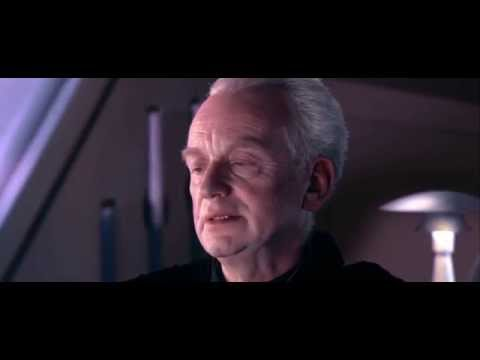

In [9]:
from IPython.display import YouTubeVideo
YouTubeVideo('jIHF8Xe-O6Y')

## Nyquist Theorem:
### We can only sample frequencies up to 1/2 of our sampling rate (i.e. up to $1/(2*dt)$

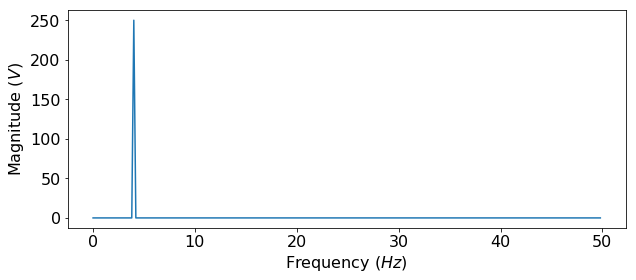

In [10]:
nyquist = int(N/2)
frequencies = frequencies[:nyquist]
magnitude = magnitude[:nyquist]
plot_magnitude(frequencies,magnitude)

## Do we care about magnitude or power?  

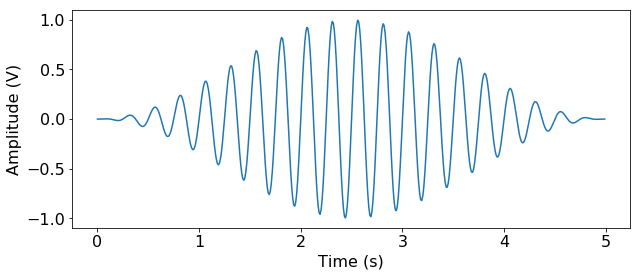

In [11]:
window = np.sin(np.pi*times/T_max)**2
signal *= window
plot_signal(times,signal)

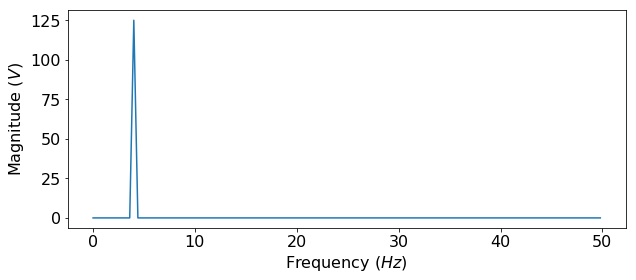

In [12]:
magnitude = np.abs(fft(signal))[:nyquist]
plot_magnitude(frequencies,magnitude)

## How much is "going on" in this signal, and how would we measure it?  

## Measuring power the easy way: The Periodogram

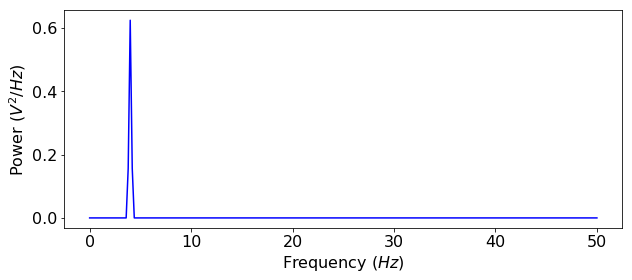

In [13]:
from scipy.signal import periodogram
frequencies, power = periodogram(signal,fs=1/dt)
def plot_periodogram(frequencies,power,color='b'):
    plt.figure(figsize=(10,4))
    plt.plot(frequencies,power,color)
    plt.xlabel('Frequency ($Hz$)')
    plt.ylabel('Power ($V^2/Hz$)') # Note that power is now 
                                   # a normalized density
plot_periodogram(frequencies,power)

## Parseval Theorem:
### The total signal energy as measured in the time domain is the same as the total signal energy as measured in the frequency domain

### There is an equal amount "going on" no matter which way you look at the signal

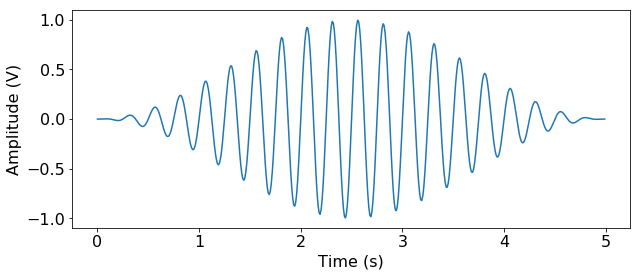

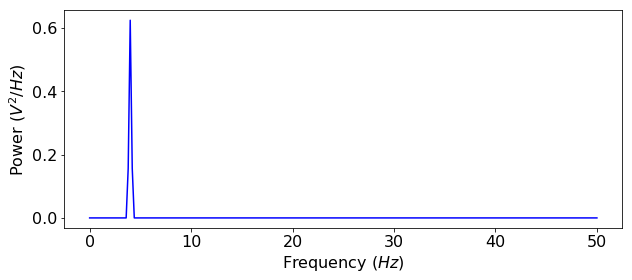

In [14]:
plot_signal(times,signal)
plot_periodogram(frequencies,power)

In [15]:
msg = "The total signal energy as measured in the %s domain is %.2f J"
print(msg % ("TIME",np.sum(signal**2)*dt))
print(msg % ("FREQUENCY",np.sum(power)))

The total signal energy as measured in the TIME domain is 0.94 J
The total signal energy as measured in the FREQUENCY domain is 0.94 J


### This is a good way to verify that your units and dimensions are correct!

## What about when the frequencies change over time?  

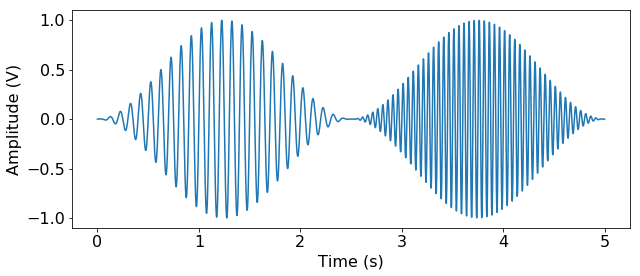

In [16]:
dt = 0.001 # 1 ms interval between points
times = np.arange(0,T_max,dt)
def make_signal(times,freq_A,freq_B):
    N = len(times)
    signal = np.array(np.sin(2*np.pi*freq_A*times))
    signal[int(N/2):] = np.array(np.sin(2*np.pi*freq_B*times[int(N/2):]))
    window = np.sin(2*np.pi*times/T_max)**2
    signal *= window
    return signal
signal = make_signal(times,10,20)
plot_signal(times,signal)

## The spectrogram: a visualization of power at a given frequency and time

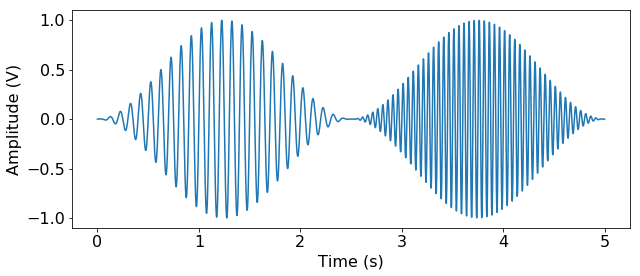

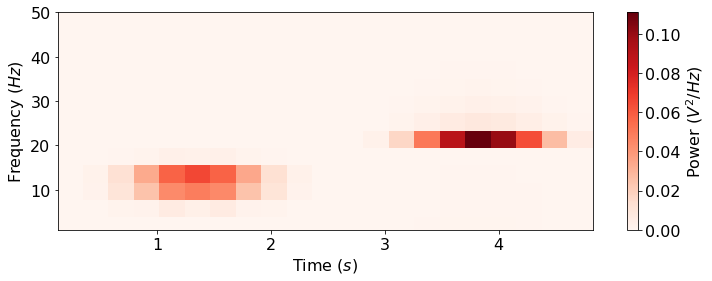

In [17]:
from scipy.signal import spectrogram
f,t,power = spectrogram(signal,fs=1/dt)
def plot_spectrogram(t,f,power,maxx=50,logg=False):
    plt.figure(figsize=(12,4))
    plt.pcolormesh(t,f,power,cmap='Reds')
    plt.xlabel('Time ($s$)')
    plt.ylabel('Frequency ($Hz$)')
    plt.colorbar().set_label('Power ($V^2/Hz$)')
    plt.ylim(1,maxx)
plot_signal(times,signal)
plot_spectrogram(t,f,power)

### There is a tradeoff between how much data can be used to estimate the frequency content at a given time and the precision of the frequency localization 

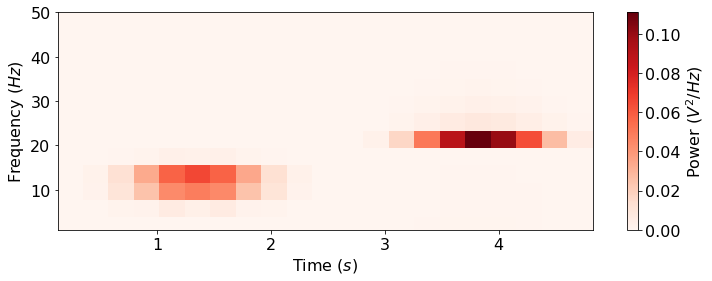

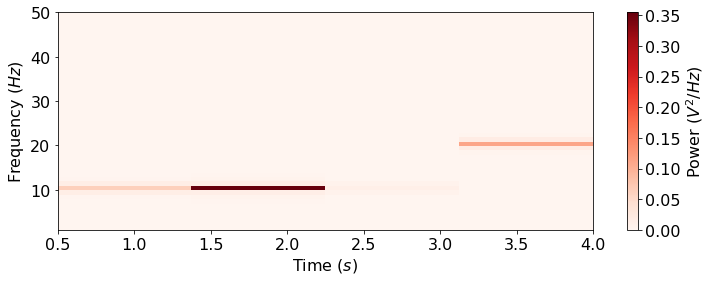

In [18]:
f,t,power = spectrogram(signal,fs=1/dt)
plot_spectrogram(t,f,power)
f,t,power = spectrogram(signal,fs=1/dt,nperseg=1000)
plot_spectrogram(t,f,power)

## Neuroscience example: Bird song

![bird-song](images/bird_song.gif)

## Embedding images in a spectrogram

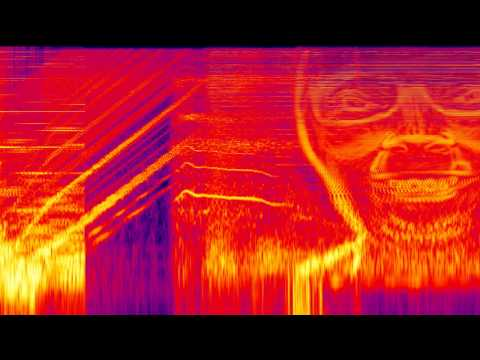

In [19]:
YouTubeVideo('wSYAZnQmffg') # Aphex Twin embeds his face into a spectrogram!
                            # Warning: this music is creepy

## The spectrogram isn't the only way to handle the tradeoff between frequency resolution and temporal resolution

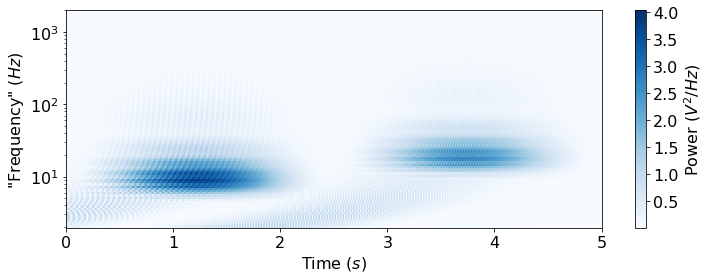

In [20]:
import pywt # A wavelet package for Python
wavelet = 'cmor' # A complex wavelet called Morlet
scales = np.logspace(-2,8,100,base=2) # Scale (stretch) this Morlet wavelet up to 128 times its smallest width
[cwt_values,frequencies] = pywt.cwt(signal,scales,wavelet,dt) # Compute the wavelet transform
def plot_scalogram(times,frequencies,cwt_values):
    plt.figure(figsize=(12,4))
    power = np.abs(cwt_values) # Get the magnitudes of the complex values
    #power = power/power.mean(axis=1)[:,np.newaxis]
    #power = np.log(power)
    plt.pcolormesh(times,frequencies,power,cmap='Blues')#,vmin=1.1)
    plt.xlabel('Time ($s$)')
    plt.ylabel('"Frequency" ($Hz$)')
    plt.yscale('log')
    plt.colorbar().set_label('Power ($V^2/Hz$)')
plot_scalogram(times,frequencies,cwt_values)

## Often, signals will only have content at a given frequency for a few cycles

## We have to have to figure out how to use:
### - a large enough window to capture both a few cycles of the slow signals
### - a small enough window to not average over the very brief fast signals

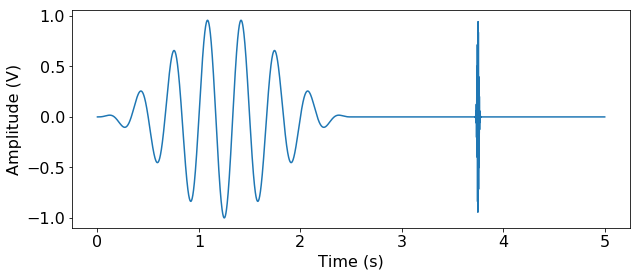

In [21]:
signal = make_signal(times,3,300)
signal[int(len(signal)/2):] *= np.sin(2*np.pi*times[int(len(times)/2):]/T_max)**10000
plot_signal(times,signal)

## The wavelet transform (and corresponding scalogram) is able to (if only barely) capture both signals

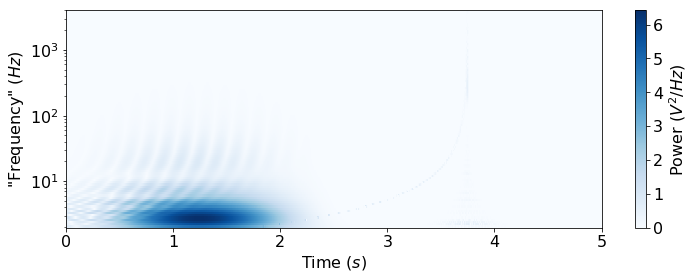

In [22]:

scales = np.logspace(-3,8,100,base=2)
[cwt_values,frequencies] = pywt.cwt(signal,scales,wavelet,dt) # Compute the wavelet transform
plot_scalogram(times,frequencies,cwt_values)

## The Fourier transform (and corresponding spectrogram) is not

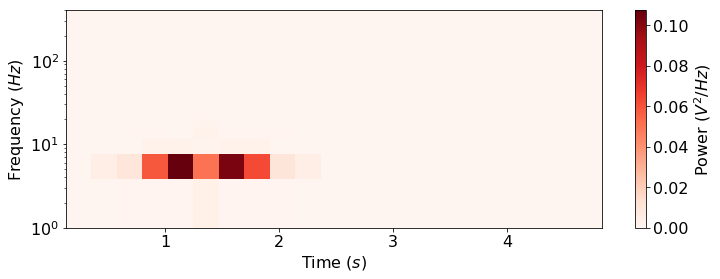

In [23]:
f,t,power = spectrogram(signal,fs=1/dt)
plot_spectrogram(t,f,power,maxx=400)
plt.yscale('log')

## Neuroscience example: EEG

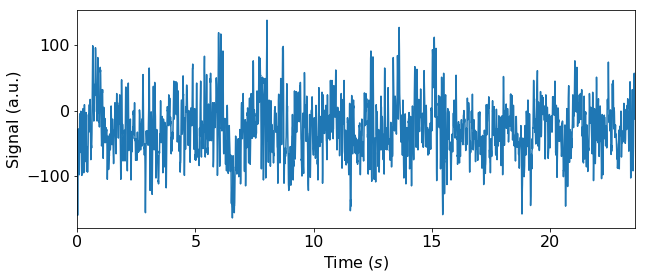

In [24]:
eeg = pd.read_csv('data/eeg/Z100.txt',header=None,names=['signal'])
dt = 1/173.61 # From http://epileptologie-bonn.de/cms/front_content.php?idcat=193&lang=3&changelang=3
eeg.index *= dt
eeg.index.name = 'Time ($s$)'
eeg.plot(figsize=(10,4))
plt.ylabel('Signal (a.u.)')
plt.legend().remove()

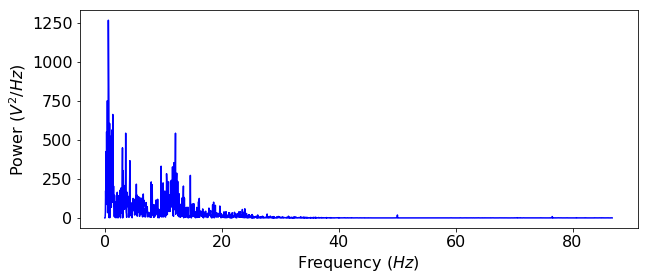

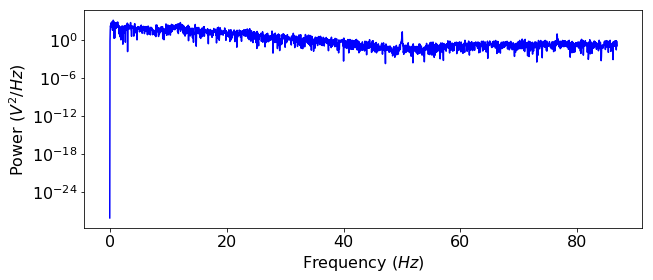

In [25]:
frequencies,power = periodogram(eeg['signal'],fs=1/dt)
plot_periodogram(frequencies,power)
plot_periodogram(frequencies,power)
plt.yscale('log')

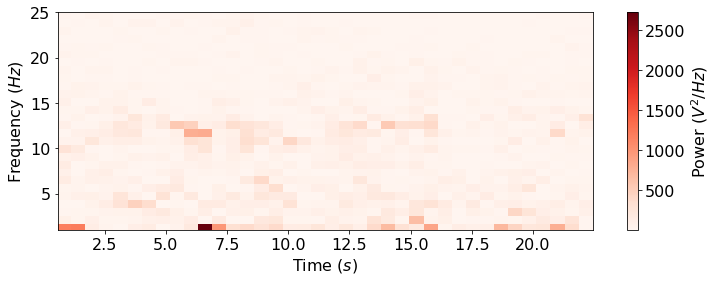

In [26]:
f,t,power = spectrogram(eeg['signal'],fs=1/dt,nperseg=200,noverlap=100)
plot_spectrogram(t,f,power,maxx=25)

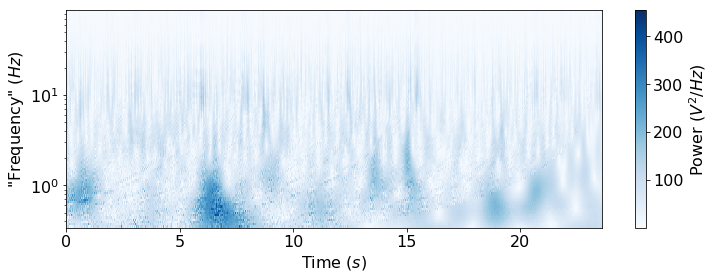

In [27]:
scales = np.logspace(0,8,100,base=2)
[cwt_values,frequencies] = pywt.cwt(eeg['signal'],scales,wavelet,dt) # Compute the wavelet transform
plot_scalogram(eeg.index,frequencies,cwt_values)

## Load the EEG data (pick a file other than Z001.txt, e.g. Z011.txt, Z021.txt, etc.)

In [28]:
# Load the EEG data
eeg = pd.read_csv('data/eeg/Z001.txt',header=None,names=['signal'])
eeg.index *= dt # We multiply by dt to turn the index from sample indices (0,1,2,...) to actual time values.  
eeg.index.name = 'Time (s)'

## Choose new values for "my_freq" and "my_amplitude" in the cell below
### The new eeg dataframe column "spiked" will then contain a modification of the original signal with the corresponding sine wave added

In [29]:
my_freq = 0 # Pick a new value here
my_amplitude = 0 # Pick a new value here
my_offset = my_amplitude+500
eeg['spiked'] = eeg['signal'] + my_offset+my_amplitude*np.sin(2*np.pi*my_freq*eeg.index)

## Plot the original signal and the "spiked" one to which a sine wave was added
### You must pick `my_amplitude` small enough that you cannot see a visible difference between the two traces.  For example, if you set my_amplitude to 1000, the difference will be very apparent (i.e. pick a smaller value).  The only difference you should see if `my_amplitude` is sufficiently small is that one trace will appear plotted above the other (due to `my_offset`).  

Text(0,0.5,'Amplitude')

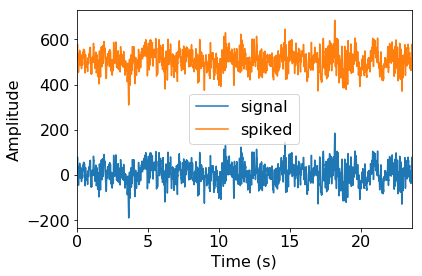

In [30]:
eeg.plot()
plt.ylabel('Amplitude')

## We compute the periodogram (the power at every frequency) for the original signal and the spiked one.  

In [31]:
frequencies,power_signal = periodogram(eeg['signal'],fs=1/dt)
frequencies,power_spiked = periodogram(eeg['spiked'],fs=1/dt)

## We plot the periodogram of the original signal, the spiked one, and the difference of the two periodograms.  
### There should be a narrow peak (a "spike") in the spiked version at the frequency you chose for `my_freq`, that stands out as much taller in the "spiked" version than in the periodogram of the original signal.  The plot of the difference of the two periodograms isolates it completely.  

### If the value of `my_amplitude` is too small, the green plot will just have a bunch of random ups and downs, instead of one clear peak corresponding to the added sine wave at `my_freq`

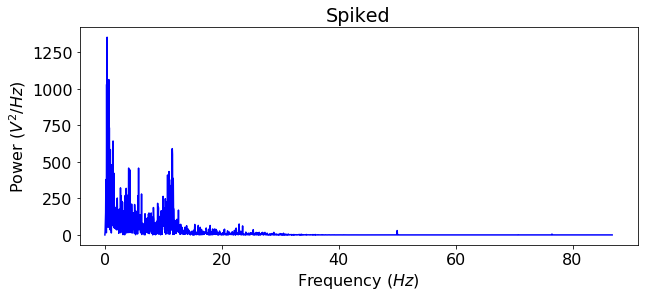

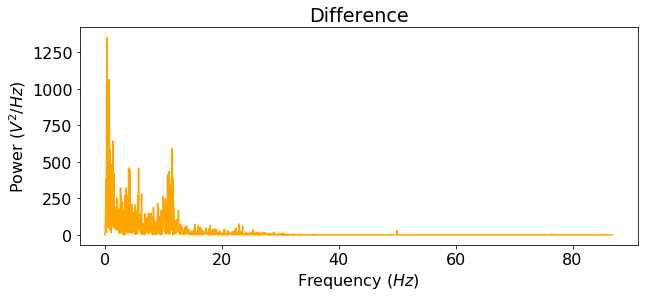

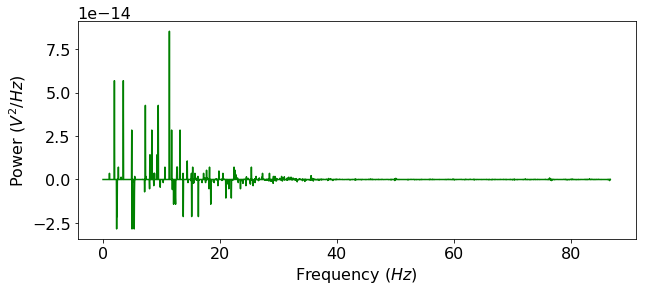

In [32]:
plot_periodogram(frequencies,power_signal)
plt.title('Signal')
plt.title('Spiked')
plot_periodogram(frequencies,power_spiked,color='orange')
plt.title('Difference')
plot_periodogram(frequencies,power_spiked-power_signal,color='green')

## Successful completion of this assignment means that the orange periodogram has a visible peak that is not present in the blue periodogram.  
## At the same time, the original plots (in the time domain), should look similar to each other.
## This illustrates that frequency domain analysis can identify features of your data that are not obvious when looking at them in the time domain.  